In [35]:
import scanpy as sc
sc.settings.n_jobs = -1
import h5py
import os, umap
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# I will fix this but i downlaoded them into a separate folder directly for now

# import GEOparse
# import os
# geo_id = "GSE234471"
# gse = GEOparse.get_GEO(geo=geo_id)
# # os.rename("../notebook_scripts/GSE234471_family.soft.gz", "../data/GSE234471_family.soft.gz")
# from urllib.request import urlretrieve
# url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE234471&format=file"
# path = "../data/GSE234471_processed.tar"
# urlretrieve(url, path)

# import gzip 
# with open('file.', 'rb') as f_in:
#     with gzip.open('file.txt.gz', 'wb') as f_out:
#         f_out.writelines(f_in)

#downloaded processed h5 data directly from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE234471

('../data/GSE234471_processed.tar', <http.client.HTTPMessage at 0x12ce76b30>)

In [65]:
# Load the filtered feature/cell matrix from HDF5
c_data = sc.read_10x_h5("../data/GSM7469255_Veh-1_filtered_feature_bc_matrix.h5")
t_data = sc.read_10x_h5("../data/GSM7469256_dTAGV-1_filtered_feature_bc_matrix.h5")

/Users/Macbook/Desktop/scrna-portfolio/scrna_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/Macbook/Desktop/scrna-portfolio/scrna_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/Macbook/Desktop/scrna-portfolio/scrna_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/Macbook/Desktop/scrna-portfolio/scrna_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [66]:
duplicates = c_data.var_names[c_data.var_names.duplicated()]
print(duplicates)

# because there are duplicates, i have to rename them
c_data.var_names_make_unique()
t_data.var_names_make_unique()

Index(['Ptp4a1', 'Arhgef4', 'Sept2', 'Zc3h11a', 'Gm16701', 'Pakap', 'Gm28710',
       'Jakmip1', 'Fam220a', 'Gm16499', 'Olfr290', 'Aldoa', 'Dpep2', 'Gm16364',
       'C730027H18Rik', 'Ddit3', 'St6galnac2', 'Gm35558', 'Ighv5-8',
       'Ighv1-13', 'Nnt', 'Gm5089', '4930594M22Rik', 'Gm41392', 'Gm38619',
       'Snhg4', 'Pcdha11', 'Gm35438', 'Btbd35f1', 'Fam90a1b', 'Ccl21b',
       'Fam205a4', 'Gm3286', 'Il11ra2', 'Ccl27a', 'Ccl21c', 'Ccl27a',
       'Il11ra2', 'Ccl19', 'Ccl21a'],
      dtype='object')


In [ ]:
## this is just me looking at the data :)
with h5py.File('../data/GSM7469255_Veh-1_filtered_feature_bc_matrix.h5', 'r') as f:
    experiment_data = f['/matrix/features/name'] 
    print(experiment_data.shape, experiment_data.dtype, hasattr(experiment_data, 'toarray'))
    #test_df = np.array(f)
    print(experiment_data[4367:4422])

(32285,) |S16 False
[b'Zfp639' b'Gm37592' b'Mfn1' b'Gnb4' b'Gm37640' b'Actl6a' b'Mrpl47'
 b'Ndufb5' b'Usp13' b'Gm37459' b'Pex5l' b'4930419G24Rik' b'Gm43666'
 b'Ttc14' b'Ccdc39' b'Gm43140' b'4930431L21Rik' b'Gm43077' b'Fxr1'
 b'Dnajc19' b'Sox2ot' b'Gm38505' b'Gm34599' b'Gm20515' b'Gm29135'
 b'Gm42695' b'Gm42205' b'Sox2' b'Gm3143' b'Gm38509' b'Gm21388'
 b'1700017M07Rik' b'Gm6639' b'Atp11b' b'Dcun1d1' b'Gm15952' b'Mccc1'
 b'Mccc1os' b'Ccdc144b' b'Acad9' b'Gm43079' b'Zfp267' b'Qrfpr' b'Gm43255'
 b'Gm42208' b'Anxa5' b'1810062G17Rik' b'Gm11548' b'Gm11549' b'Exosc9'
 b'Ccna2' b'Bbs7' b'Trpc3' b'4932438A13Rik' b'Gm12531']


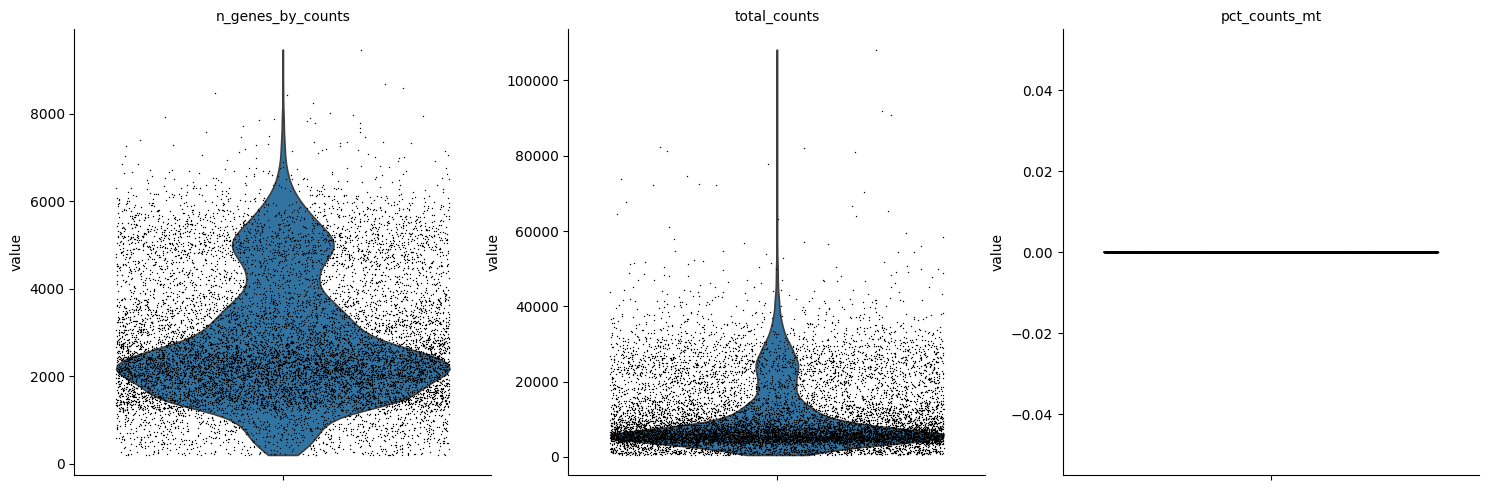

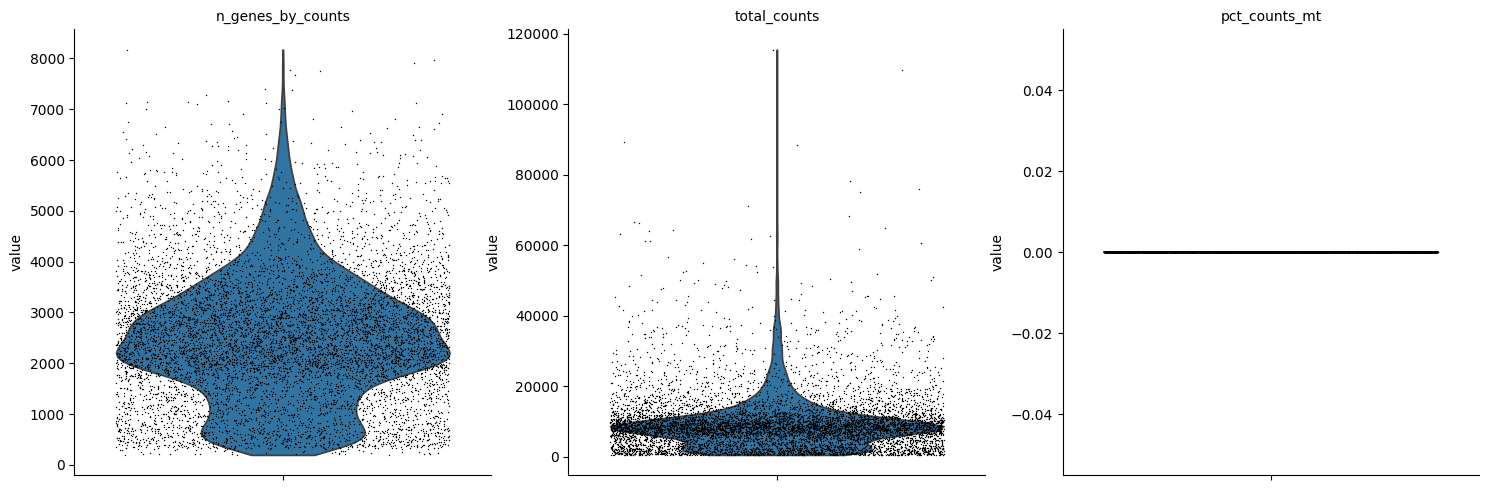

In [67]:
# preprocessing
def preprocessing(adata):
    sc.pp.filter_cells(adata, min_genes=200)  # TODO adjust min genes
    sc.pp.filter_genes(adata, min_cells=3)    # TODO adjust min cells
    adata.var["mt"] = adata.var_names.str.startswith("MT-") # Identify mitochondrial genes
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    ) #this confirms no mitochondrial data, high-quality data

    #sc.pp.scrublet(adata, batch_key="sample") #TODO resolve
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
preprocessing(c_data)
preprocessing(t_data)

In [ ]:
#probably don't need this anymore
c_df = c_data.to_df()
t_df = t_data.to_df()

,Ptp4a1,Ptp4a1
AAACCCAAGCTAGTTC-1,0.0,0.0
AAACCCAAGGGACTGT-1,0.0,0.0
AAACCCAAGGGAGTTC-1,0.0,0.0
AAACCCAAGGTACTGG-1,0.0,0.0
AAACCCAAGTCTGGTT-1,0.0,0.0
...,...,...
TTTGTTGGTGCGGATA-1,0.0,0.0
TTTGTTGGTTATGTGC-1,0.0,0.0
TTTGTTGGTTCTCCAC-1,0.0,0.0
TTTGTTGTCCCTCGAT-1,0.0,0.0


/Users/Macbook/Desktop/scrna-portfolio/scrna_env/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


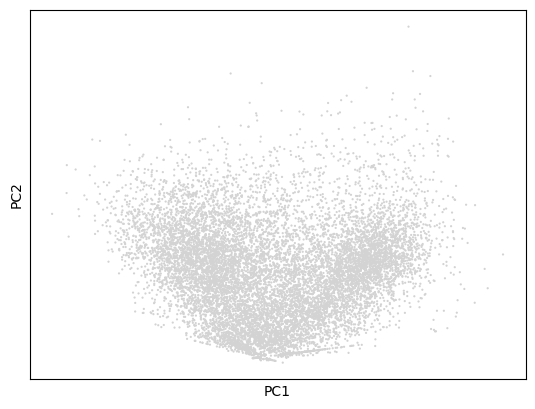

In [ ]:
# CONTROL
sc.pp.highly_variable_genes(c_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
c_data = c_data[:, c_data.var.highly_variable]

# Scale the data and perform PCA
sc.pp.scale(c_data, max_value=10)
sc.tl.pca(c_data, svd_solver='arpack')
sc.pl.pca(c_data)

# Compute neighborhood graph
sc.pp.neighbors(c_data, n_neighbors=15, n_pcs=10)

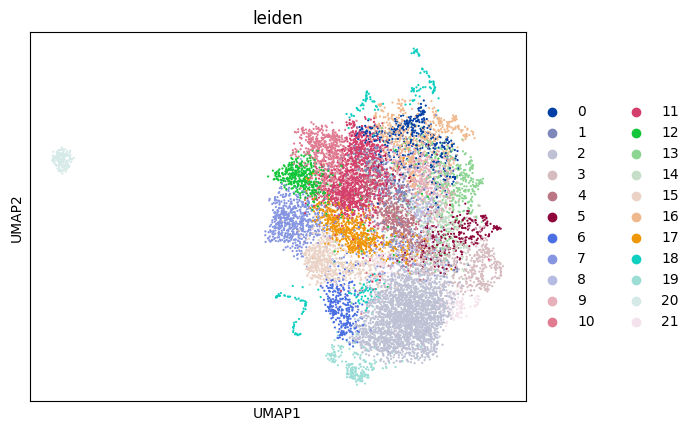

In [76]:
# Plot UMAP
sc.tl.leiden(c_data, flavor="igraph", n_iterations=2)
sc.tl.umap(c_data)
sc.pl.umap(c_data, color=["leiden"])

In [ ]:
#control_umap = umap.UMAP()
# embedding = pd.DataFrame(control_umap.fit_transform(c_df), columns = ['UMAP1','UMAP2'])

# # Produce sns.scatterplot 
# sns_plot = sns.scatterplot(x='UMAP1', y='UMAP2', data=embedding,
#                 #hue=metadata.subclass_label.to_list(),
#                 alpha=.1, linewidth=0, s=1)
# # Adjust legend
# sns_plot.legend(loc='center left', bbox_to_anchor=(1, .5))
# # Save PNG
# sns_plot.figure.savefig('../results/umap_scatter.png', bbox_inches='tight', dpi=500)

AttributeError: module 'umap' has no attribute 'UMAP'